In [1]:
import torch
import tensorflow as tf

FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.3168797;
FastEstimator-Train: step: 100; ce: 0.2790169; steps/sec: 121.27;
FastEstimator-Train: step: 200; ce: 0.26774406; steps/sec: 120.73;
FastEstimator-Train: step: 300; ce: 0.20722145; steps/sec: 121.51;
FastEstimator-Train: step: 400; ce: 0.08050096; steps/sec: 119.33;
FastEstimator-Train: step: 500; ce: 0.08282061; steps/sec: 116.4;
FastEstimator-Tr

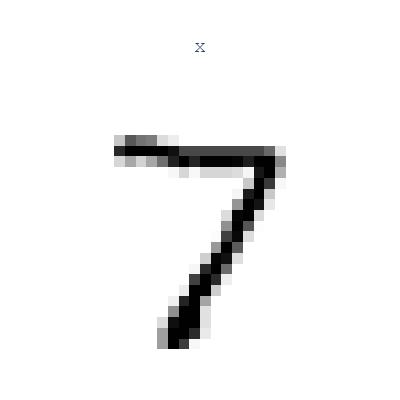

In [2]:
# Test if the Fastestimator library works

import fastestimator as fe
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

train_data, eval_data = mnist.load_data()

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")])

from fastestimator.architecture.tensorflow import LeNet
# from fastestimator.architecture.pytorch import LeNet  # One can also use a pytorch model

from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce") 
    ])

from fastestimator.trace.metric import Accuracy
from fastestimator.trace.io import BestModelSaver
import tempfile

traces = [Accuracy(true_key="y", pred_key="y_pred"),
          BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="accuracy", save_best_mode="max")]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=2,
                         traces=traces)

estimator.fit()

import numpy as np

data = eval_data[0]
data = pipeline.transform(data, mode="eval")
data = network.transform(data, mode="eval")

print("Ground truth class is {}".format(data["y"][0]))
print("Predicted class is {}".format(np.argmax(data["y_pred"])))
img = fe.util.BatchDisplay(title="x", image=data["x"])
img.show()

In [3]:
# Get the location of the data
FOLDER = '../manifest-1557326747206'
# If n_samples=0 you load all data
n_samples = 0

import pandas as pd

df = pd.read_csv(f'{FOLDER}/metadata.csv')
df_locations = df[['Data Description URI', 'Manufacturer', 'File Location']]

# After this sort the locations will be like: test1-CT, test1-RT, test2-CT, test2-RT, ...
df_locations = df_locations.sort_values(['Data Description URI', 'Manufacturer'])

# Reduce data size for testing purposes
if n_samples != 0: df_locations = df_locations.iloc[:n_samples * 2]

In [4]:
# Read in and preprocess the data
import numpy as np
import SimpleITK as sitk
import pydicom
from sklearn.model_selection import ShuffleSplit

def get_metadata(path):
    '''Get metadata from an RT file.'''
    path = FOLDER + path.replace('\\', '/').strip('.') + '/1-1.dcm'
    ds = pydicom.dcmread(path)
    gender = ds[0x0010, 0x0040].value
    return gender

X = []
y = []

for ct, rt in zip(df_locations['File Location'][0::2], df_locations['File Location'][1::2]):
    # Read in CT-s
    path = FOLDER + ct.replace('\\', '/').strip('.')
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    npa = sitk.GetArrayViewFromImage(image)
    
    # MIP projection
    mip = np.amax(npa, axis=0)
    X.append(mip)
    
    gender = get_metadata(rt)
    y.append(gender)

X = np.array(X)
y = (np.array(y) == 'M').astype('int')

tr, te = next(ShuffleSplit(test_size=0.3, random_state=42).split(y))

In [5]:
from tensorflow.keras import Sequential, layers

# Modified code from FastEstimator's Github.
def LeNet(input_shape: (int, int, int) = (512, 512, 1), classes: int = 2) -> tf.keras.Model:
    """A standard LeNet implementation in TensorFlow.

    The LeNet model has 3 convolution layers and 2 dense layers.

    Args:
        input_shape: shape of the input data (height, width, channels).
        classes: The number of outputs the model should generate.

    Raises:
        ValueError: Length of `input_shape` is not 3.
        ValueError: `input_shape`[0] or `input_shape`[1] is smaller than 18.

    Returns:
        A TensorFlow LeNet model.
    """
    _check_input_shape(input_shape)
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(classes, activation='softmax'))
    return model


def _check_input_shape(input_shape):
    if len(input_shape) != 3:
        raise ValueError("Length of `input_shape` is not 3 (channel, height, width)")

    height, width, _ = input_shape

    if height < 18 or width < 18:
        raise ValueError("Both height and width of input_shape need to not smaller than 18")

In [14]:
# Changes compared to the example:
# decreased batch size, and increased number of epochs because we have a small dataset

import torch
import tensorflow as tf

import fastestimator as fe
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

train_data = fe.dataset.NumpyDataset({"x": X[tr], "y": y[tr]})
eval_data = fe.dataset.NumpyDataset({"x": X[te], "y": y[te]})

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=2,
                       ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")])

# from fastestimator.architecture.tensorflow import LeNet
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce") 
    ])

from fastestimator.trace.metric import Accuracy
from fastestimator.trace.io import BestModelSaver
import tempfile

traces = [Accuracy(true_key="y", pred_key="y_pred"),
          BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="accuracy", save_best_mode="max")]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=10,
                         traces=traces)

estimator.fit()

FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
FastEstimator-Train: step: 1; ce: 0.6874868;
FastEstimator-Train: step: 21; epoch: 1; epoch_time: 7.7 sec;
Eval Progress: 1/9;
Eval Progress: 3/9; steps/sec: 17.06;
Eval Progress: 6/9; steps/sec: 19.93;
Eval Progress: 9/9; steps/sec: 20.58;
FastEstimator-BestModelSaver: Saved model to C:\Users\zanma\AppData\Local\Temp\tmp_g38208u\model5_best_accuracy.h5
FastEstimator-Eval: step: 21; epoch: 1

Ground truth class is 1
Predicted class is 1


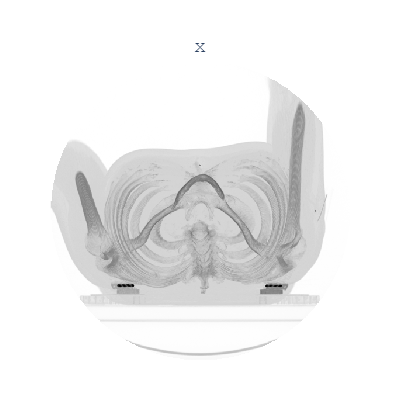

In [15]:
import numpy as np

data = eval_data[0]
data = pipeline.transform(data, mode="eval")
data = network.transform(data, mode="eval")

print("Ground truth class is {}".format(data["y"][0]))
print("Predicted class is {}".format(np.argmax(data["y_pred"])))
img = fe.util.BatchDisplay(title="x", image=data["x"])
img.show()

In [20]:
# Accuracy that we can get with a dummy model.
max(y[tr].mean(), 1 - y[tr].mean())

0.5238095238095238